In [18]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from models import DeepConditionalModel, InvariantNetwork
from inn_utils import train_loop_dataset
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc

In [2]:
np.set_printoptions(suppress=True)

In [3]:
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

# Data loader for seqRNA matrices

In [5]:
class RNADataLoader:
    """A class to sequentially load batches of seq RNA matrices."""
    def __init__(self, batch_size=32, data_path='.', normalize=True, log=True,
                 shuffle=True, n_cells=20, n_genes=20, n_sim_chunk=10000):
        
        self.data_path = data_path
        self._batch_size = batch_size
        self._n_cells = n_cells
        self._n_genes = n_genes
        self._n_sim = n_sim_chunk
        self._idx = 0
        self._log = log
        self._normalize = normalize
        self._shuffle = shuffle
        self._num_chunks = self._get_num_chunks()
        self._data_files_list = self._get_data_files()
        self._param_files_list = self._get_param_files()
        assert len(self._data_files_list) == len(self._param_files_list), '# Data files in {} must equal # params files'.format(self.path)
        
        self._global_max = 0
        # This takes time
        if self._normalize:
            self._get_global_max()        
        if self._shuffle:
            self._shuffle_chunks()

    
    def _shuffle_chunks(self):
        """Shuffles the order of the chunks."""

        self._data_files_list, self._param_files_list = shuffle(self._data_files_list, self._param_files_list)
    
    def _get_num_chunks(self):
        
        return len(os.listdir(os.path.join(self.data_path, 'data'))) 
    
    def _get_data_files(self):
        
        return [os.path.join(self.data_path, 'data', f) 
                for f in os.listdir(os.path.join(self.data_path, 'data'))]
    
    def _get_param_files(self):
        
        return [os.path.join(self.data_path, 'params', f) 
                for f in os.listdir(os.path.join(self.data_path, 'params'))]
    
    def _get_global_max(self):
        """Determines the global maximum count over all counts dataset."""
        
        self._global_max = 0
        for data_file in self._data_files_list:
            X = np.load(data_file).astype(np.float32)
            # Log, if true
            if self._log:
                X = np.log1p(X)
            max_count = np.max(X)
            if max_count > self._global_max:
                self._global_max = max_count
        print('Global max determined: ', self._global_max)
            
    
    def load_test(self, n_test, path='.', to_tensor=True):
        """Loads a test dataset."""
        
        X = np.load(os.path.join(path, 'test', 'rna_data_test.npy')).astype(np.float32)
        y = np.load(os.path.join(path, 'test', 'rna_params_test.npy')).astype(np.float32)
        X = X.reshape(self._n_genes, self._n_cells, n_test).T
        if self._log:
            X = np.log1p(X)
        if to_tensor:
            X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        return X, y
    
    def _load_next(self):
        """Loads the current data files."""
        
        # Make sure a corresponding pair of data-params is loaded
        data_file = self._data_files_list[self._idx]
        params_file = self._param_files_list[self._idx]
        assert data_file.split('_')[-1] == params_file.split('_')[-1]
        
        # Load as numpy
        X = np.load(data_file).astype(np.float32)
        y = np.load(params_file).astype(np.float32)
        
        # Convert to N_sim x Genes x Cells tensor
        X = X.reshape(self._n_genes, self._n_cells, self._n_sim).T
        
        # Log, if true
        if self._log:
            X = np.log1p(X)
        
        # Normalize
        if self._normalize:
            X /= self._global_max
            
        
        # Create a tf dataset
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(X.shape[0]).batch(self._batch_size)

        # Increment index and return dataset
        self._idx = self._idx + 1
        return dataset
    
    def __iter__(self): 
        return self
    
    def __next__(self):
        # Increment index and check if we are at the end of the file list 
        if self._idx == self._num_chunks:
            self._idx = 0
            if self._shuffle:
                self._shuffle_chunks()
            raise StopIteration
        return self._load_next()

In [6]:
class InvariantSummary(tf.keras.Model):
    
    def __init__(self, summary_dim, n_equiv=3):
        super(InvariantSummary, self).__init__()
        
        self.bn = tf.keras.layers.BatchNormalization()
        self.inv = InvariantNetwork(summary_dim, n_equiv)
       
    def call(self, x, training=True):
        """Input is a matrix."""
        
        x = self.bn(x, training=training)
        x = self.inv(x)
        return x
        

class SelfAttentionHead(tf.keras.Model):
    def __init__(self, key_dim=64, dense_dim=128):
        super(SelfAttentionHead, self).__init__()
        
        self.Wq = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.Wk = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.Wv = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        
        self.dense_part = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
        ])
        
        
        self.scale = np.sqrt(key_dim)
              
    def call(self, x):
        
        # Obtain queries, keys, and values
        queries = self.Wq(x)
        keys = self.Wk(x)
        values = self.Wv(x)
        
        # Compute self-attention
        qk_t = tf.einsum('bij,bkj->bik', queries, keys)
        weights = tf.nn.softmax(qk_t / self.scale, axis=-1)
        z = tf.einsum('bik,bkj->bij', weights, values)
        
        # Pass through dense
        o = self.dense_part(z)
        return o
    

class AttentionNetwork(tf.keras.Model):
    
    def __init__(self, n_heads=8, key_dim=32, dense_dim=128):
        super(AttentionNetwork, self).__init__()
        
        self.bn = tf.keras.layers.BatchNormalization()
        self.Wo = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.attention_heads = [SelfAttentionHead(key_dim) for _ in range(n_heads)]
        
        self.dense_part = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
        ])
        
    def call(self, x, training=True):
        
        # Calculate attention
        x = self.bn(x, training=training)
        x = tf.concat([head(x) for head in self.attention_heads], axis=-1)
        x = self.Wo(x)
        
        # Pooling
        x = tf.reduce_sum(x, axis=1)
        
        # Non-lineariy after pooling
        o = self.dense_part(x)
        return o
  

class GraphNetwork(tf.keras.Model):
    """
    Implements a simple graph network as in Xu et al. (2019).
    """
    
    def __init__(self, k=5, n_dense=3, dense_dim=64):
        super(GraphNetwork, self).__init__()
        
        self.bn = tf.keras.layers.BatchNormalization()
        self.mlp1_list = [
            tf.keras.Sequential([
                tf.keras.layers.Dense(dense_dim, 
                                      activation='elu', 
                                      kernel_initializer='glorot_uniform')
                for _ in range(dense_dim)]
            )
            for _ in range(k)
        ]
 

        self.mlp2 = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
        ])
        
    def call(self, x, training=True):
        
        
        x = self.bn(x, training=training)
        outputs_k = x
        
        # Compute pairwise interactions 
        for k, mlp in enumerate(self.mlp1_list):
            
            outputs_k = self.pairwise_concat(outputs_k)
            outputs_k = mlp(outputs_k)
            outputs_k = tf.reduce_sum(outputs_k, axis=2)
            
        # Calculate final output
        o = tf.reduce_sum(outputs_k, axis=1)
        o = self.mlp2(o)
        return o
        
        
    def pairwise_concat(self, x):
        """
        Transforms 3D to 4D (pairwise concatenates all observations).
        """
        
        b = x.shape[0]
        n = x.shape[1]
        d = x.shape[2]
        
        x_tiled = tf.reshape(tf.tile(x, [1, n, 1]), (b, n, n, d))
        x_tiled_t = tf.transpose(x_tiled, [0, 2, 1, 3])
        x = tf.concat((x_tiled_t, x_tiled), axis=-1)
        return x 

# Initialization 

In [8]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
param_names = [r'$\alpha$', r'$\beta$', r'$\mu^{O}$', r'$\pi^{O}$', 
               r'$\sigma^{O}$', r'$\mu^{L}$', r'$\sigma^{L}$', r'$\phi$']
theta_dim = 8
summary_dim = 128
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 50
n_inv_blocks = 10
data_path = 'D:\\seqRNA'
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 31250
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [10]:
# --- Data loader --- #
n_chunks = 20
n_sim_chunk = 10000
n_genes = 100
n_cells = 40
data_loader  = RNADataLoader(batch_size, data_path, normalize=False, log=True,
                             n_sim_chunk=n_sim_chunk, n_cells=n_cells, n_genes=n_genes)

## Create a test set

In [43]:
X_test, theta_test = data_loader.load_test(n_test=300, path=data_path)

## Create networks

In [55]:
summary_net = AttentionNetwork()
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, 
                            summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=starter_learning_rate)

## Checkpoint manager

In [60]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/seqrna', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/seqrna\ckpt-final


## Plot performance of untrained model

Instructions for updating:
Colocations handled automatically by placer.


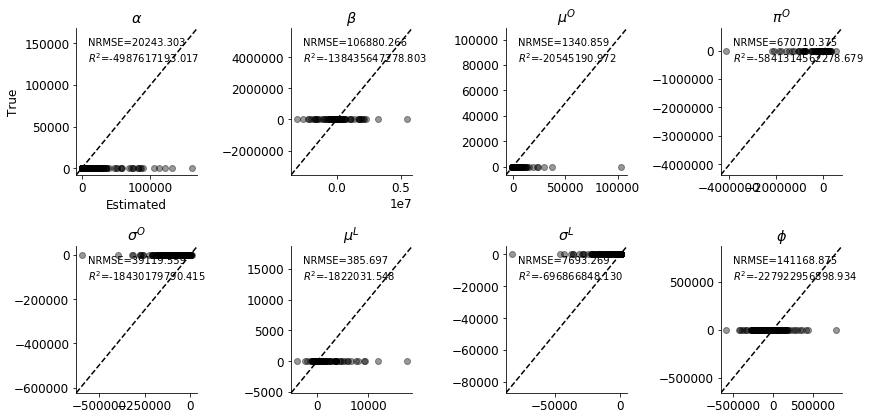

In [15]:
plot_true_est_scatter(model, X_test, theta_test, 
                      n_samples_posterior, param_names, figsize=(12, 6))

# Train the model

In [58]:
for ep in range(1, epochs+1):
    with tqdm(total=n_chunks * n_sim_chunk // batch_size, desc='Epoch {}'.format(ep)) as p_bar:
        # One loop over the chunk
        for chunk in data_loader:
            losses = train_loop_dataset(model, optimizer, chunk, batch_size, p_bar, 
                                        clip_value=clip_value, global_step=global_step, 
                                        transform=None)
    # Plot stuff
    plot_true_est_scatter(model, X_test, theta_test, 
              n_samples_posterior, param_names, figsize=(12, 6))
    plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))
    # Save model
    manager.save()

# Evaluate the model

## Recovery

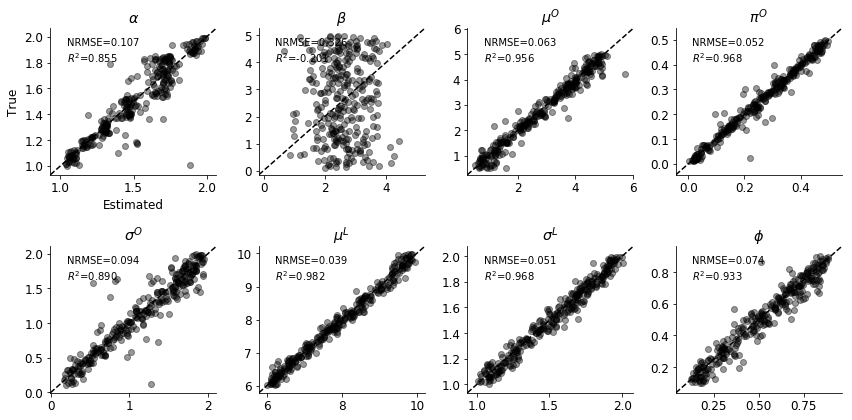

In [51]:
plot_true_est_scatter(model, X_test, theta_test, 
                      n_samples_posterior, param_names, figsize=(12, 6), filename='RNA')

## SBC

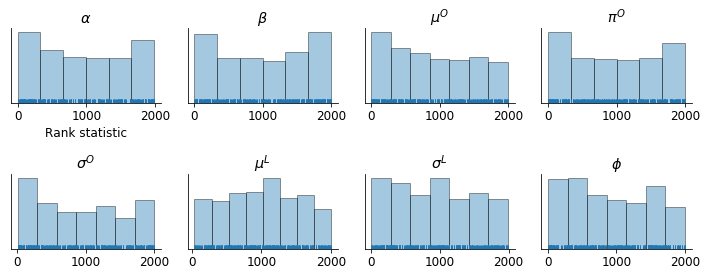

In [52]:
plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4), filename='RNA')

## Posterior samples

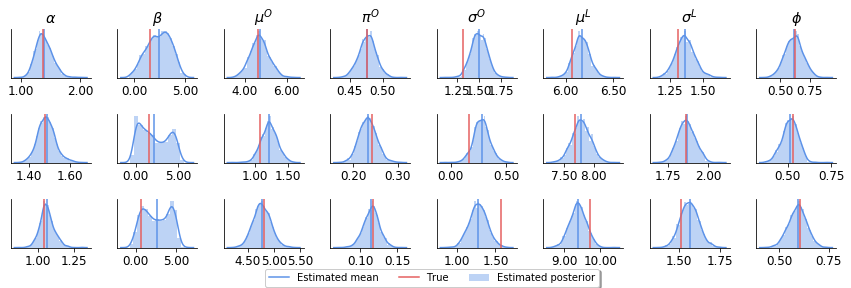

In [54]:
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:3], theta_test=theta_test[:3], figsize=(12, 4), 
                        tight=True, filename='RNA')

## Speed of inference

In [59]:
%timeit model.sample(X_test, n_samples_posterior)

1.65 s ± 37.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
